# Pnemonia Detection from Chest Xrays

## Problem/Background

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.  Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.  Diagnosis of pnemonia is typically done from one or a combination of the following:

*   Blood tests
*   Chest X-ray
*   Pulse oximetry
*   Sputum test
*   CT scan
*   Pleural fluid culture

[Src: Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/pneumonia/diagnosis-treatment/drc-20354210)

While doctors typically do well at making diagnosis via Chest X-ray they are humans who are often overworked and can suffer from fatigue which can hamper their ability to make a proper diagnosis.  A machine learning model can be used to help reduce the false negative rate by acting as a second opinion.  In this notebook we will attempt to create said model.  The dataset we will be using consists of approximately 6000 images of chest xrays to train a convolutional neural network to detect whether a person has virus-related pnemonia, bacteria-related pnemonia, or neither.
 

The dataset is [located here.](https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset)

## Goals and Success Metrics


Our main goal is to minimize false negatives (True: Pneumonia, Predicted: Normal).  A search was done to try to determine false negative rates by medical professionals, but that yeilded mixed results.  We have arbitrarily chosen 2% as our maximum allowed rate of false negatives.  The reasoning being that in order for a model to be trusted by a medical professional, it must perform exceptionally well.

Secondary goal is to minimize false positives.  Again, no false positive rate was discovered for medical professionals, so we will be arbitrarily chosing this value which will be set at 10% being the maximum allowable amount of false positives. 

We would also like our model to be able to differentiate between different causes of pneumonia, however, we will not be factoring this into our success metrics.

## Assumptions and Risks

#### Assumptions: 
* Our data has been labeled correctly by medical experts and are as close to ground truth as possible.
 

* The data represents a many different groups of people. 


* Personally identifiable information has been stripped from the images.


* From our EDA, we have discovered a small number of CT Scans were included in the dataset.  They seemed to be multiple scans from the same patients.  We are assuming that our train and test sets are independant of one another in that scans or images of one person aren't included in both datasets.

#### Risks:
* A risk that we have with this dataset is not having enough data. There are some things we can (and likely will) do to combat this. Things such as random shifts, adding noise, rotations, etc. These will be eplained more in the pipeline section.

* If our data is only representative of a certain group (ie: Males aged 30-35) than our model could potentially perform poorly and have high false negative rates for other groups.

## Overview

There general structure of this project will be as follows:
1. Data Importing/EDA
2. Input Pipeline
3. Modeling
4. Model evaluation
5. Conclusions
6. Next steps

#### Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms, utils
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")

# CUDA_LAUNCH_BLOCKING=1
torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
print(torch.cuda.get_device_name(0))

Tesla T4


In [42]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from seaborn import pairplot
plt.ion()   # interactive mode
import time
import os
import copy
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

## 1. Data Importing / EDA


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The dataset curators have kindly included a helpful summary about the dataset.  Let's take a look:

In [5]:
base_path = '/content/drive/MyDrive/Colab Notebooks/data/'
summary = pd.read_csv(base_path + 'Chest_xray_Corona_dataset_Summary.csv')
summary = summary.drop('Unnamed: 0',axis=1)
summary

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,NaN,NaN,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,NaN,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,NaN,2772
6,Pnemonia,bacteria,Streptococcus,5


In [ ]:
summary['Image_Count'].sum()

5910

There are two main labels: 'Normal', and 'Pnemonia'. Roughly 75% of our data falls under 'Pnemonia'. This can cause problems due to class imbalance. Luckily, we have secondary (and tertiary) labels which will help us split the dataset more evenly. The labels we will use are: 'Normal','Virus',and 'bacteria'. As tempting as it is to go after 'COVID-19', there are only 58 cases under that label, so it seems like an exercise in futility. Perhaps if time allows, we can try to build a model that maximises for classifying 'COVID-19'.

The class labels are included in the 'Chest_xray_Corona_Metadata.csv' file. We have one level of labels for 'Normal', and three levels available for 'Pnemonia'.

### Labels
Our labels are contained in the metadata csv.

In [7]:
metadata = pd.read_csv(base_path + 'Chest_xray_Corona_Metadata.csv')
metadata = metadata.drop('Unnamed: 0',axis=1)
metadata.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [ ]:
metadata.tail() #It looks like our train and test sets are both included in the file

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5905,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus
5909,person1632_virus_2827.jpeg,Pnemonia,TEST,NaN,Virus


The Label_1_Virus_category column has all the information we need to create our encoded labels.  It shows 'Virus', 'bacteria', or NaN if the image is 'Normal'.  We can map the values to integers to get our encoded labels.

0 : 'Normal'

1 : 'Virus'

2 : 'bacteria'

In [8]:
#encoding labels
metadata['labels_enc'] = metadata['Label_1_Virus_category'].map({np.nan:0, 'Virus':1,'bacteria':2})
metadata['labels_enc'].value_counts()

2.0    2777
0.0    1576
1.0    1555
Name: labels_enc, dtype: int64

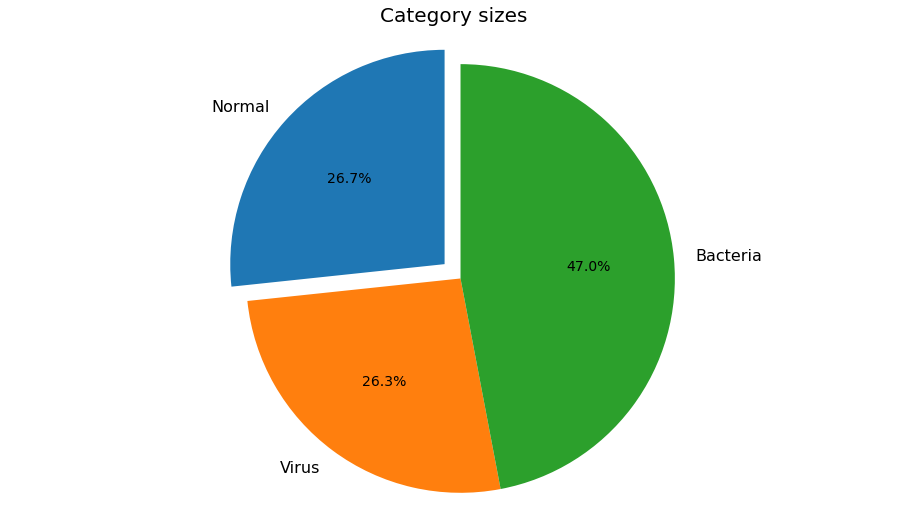

In [9]:
#starter code here: https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py

labels = 'Normal', 'Virus', 'Bacteria'
sizes = [1576, 1555, 2777]
explode = (0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(16,9))

patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
for text in texts:
    text.set_fontsize(16)
for autotext in autotexts:
    autotext.set_fontsize(14)
ax1.set_title('Category sizes',fontsize=20)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Looking at the chart above we can see there is a bit of class imbalance with 'bacteria' making up 47% of our data, and our other 2 classes being nearly equal. This shouldn't be too much of an issue, but we could potentially benefit from over/undersample teqniques.

Our data metadata does include sublabels for bacteria and virus, but many of those class sizes are much too small to be useful on their own.  This is somewhat dissapointing as the class for Covid 19 only has 58 samples.  We will talk about this more in the 'Next steps' section later.

### Images
Our image files are stored in another folder.  We don't have room to fit them all into memory at once, so we will just be getting the paths to the images for now.

In [10]:
df_whole = metadata[['X_ray_image_name','labels_enc']]
df_whole = df_whole.rename(columns={'X_ray_image_name': 'image_paths', 'labels_enc':'labels'})
#dropping samples with missing labels (there were only 2)
df_whole['labels'] = df_whole['labels'].fillna(0)
#pytorch requires labels be int64
df_whole['labels'] = df_whole['labels'].astype('int64')

Our 'metadata' file contains the end paths for both train and test images (which are contained in separate folders).  The train set contains 5286 images, so we will split our complete dataset on that.

In [11]:
df_train = df_whole.iloc[:5286]
df_test = df_whole.iloc[5286:]
df_test = df_test.reset_index(drop=True)

### Visualizing Images
Now that we have our labels and image paths organinzed, let's view some of the images from each label to try an gain a little intuition into our problem.

In [ ]:
#creating new dataframes to make visualizing a little easier
df_normal = df_whole.loc[df_whole['labels'] == 0]
df_virus = df_whole.loc[df_whole['labels'] == 1]
df_bacteria = df_whole.loc[df_whole['labels'] == 2]

In [ ]:
#Helper function to plot images
def visualize_images(imgs, title):
    imgs = list(imgs) #convert series to list so we can iterate    
    plt.figure(figsize=(25,25))
    for i in range(0,25,5): #large increments to skip over similar imgs
        j = i / 5 #to adjust for subplot alignment
        plt.subplot(1,5, j+1)
        im = Image.open(base_path + 'train/'+imgs[i])
        plt.imshow(im,cmap='gray')
        plt.title(title,fontsize=30)
        plt.xticks([]) , plt.yticks([])
    plt.show()

Now let's check out some images and see what we can learn...

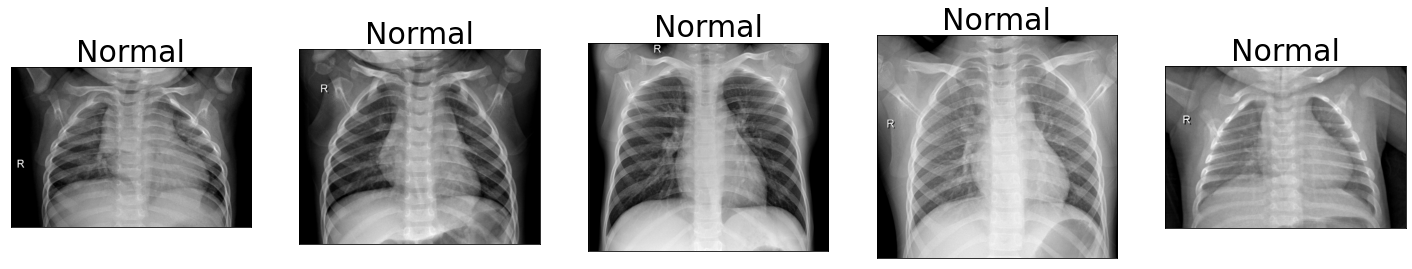

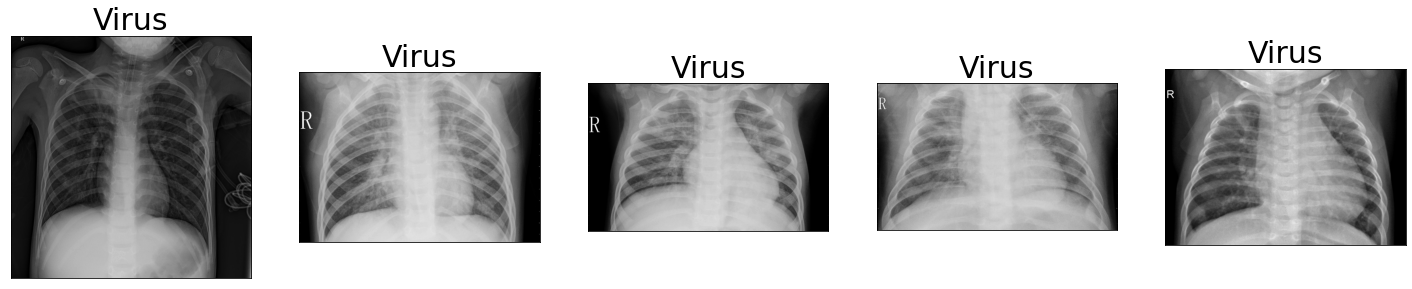

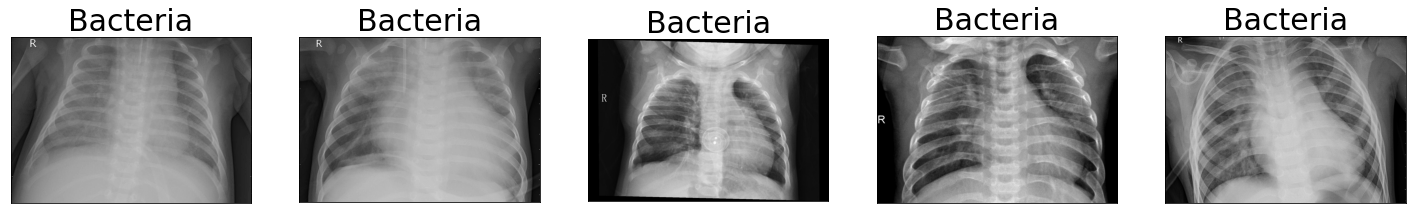

In [ ]:
visualize_images(df_normal['image_paths'], "Normal")
visualize_images(df_virus['image_paths'], "Virus")
visualize_images(df_bacteria['image_paths'], "Bacteria")

After viewing many different images, it is not clear what the distinguishing features of pneumonia are.  This brings up one of the assumptions we will be making in that the images are properly labeled by medical professionals.

Some other findings are: 

*   Majority of images are xrays (although a small amount of CT scans are present)
*   Images greatly vary in size (we will explore this later)
*   There is some amount of discrepency with the cropping (some show just the chest, while other are zoomed out slighltly and include shoulders/bits of arms)
*   There is some slight variation in rotation (spines not always vertical)
*   Brightness/contrast levels are not extremely uniform (perhaps due to different xray machines?)
*   There seems to be uniformity in flipping along the vertical access.  The majority of the images we explored have an 'R' to indicate the person's right side, which shows up on the left side of the images.



### Image Sizes
We are going to need to make sure our images are of uniform shape in order to feed into our model.  If we make a random guess as to what size we use, we could end up loosing a lot of information (from downsampling), or we might be making up information (from upsampling).  In order to make a more informed decision, we will gather all of the image sizes into a dataframe and do a little exploration.

The next two cell blocks iterate through our train and test folders and get the height and width of each image.  We will then concatenate them together in a dataframe and create a third column which is the ratio.

In [ ]:
import imagesize

train_sizes = []

#Gets the width and height of each image
for i in range(len(df_train['image_paths'])):
  width, height = imagesize.get(base_path + 'train/'+ df_train['image_paths'].iloc[i])
  sizes = {'width': width, 'height': height}
  train_sizes.append(sizes)

  #Adds a bit of verbosity.
  if i % 1000 == 0: 
    print(i)

train_sizes = pd.DataFrame(train_sizes)
train_sizes.head()

In [ ]:
test_sizes = []

#Gets the width and height of each image
for i in range(len(df_test['image_paths'])):
  width, height = imagesize.get(base_path + 'test/'+ df_test['image_paths'].iloc[i])
  sizes = {'width': width, 'height': height}
  test_sizes.append(sizes)

  #Adds a bit of verbosity.
  if i % 100 == 0: 
    print(i)

test_sizes = pd.DataFrame(test_sizes)
test_sizes.head()

In [ ]:
#Adding the train and test sizes into the same df
sizes_df = pd.concat([train_sizes,test_sizes])

In [ ]:
#Creating the ratio column
sizes_df['ratio'] = sizes_df['height'] / sizes_df['width']

In [ ]:
#Saving so we don't have to re-run the code above.
sizes_df.to_csv(base_path + 'sizes.csv',index = False)

In [ ]:
#Loading the csv
sizes_df = pd.read_csv(base_path + 'sizes.csv')
sizes_df.head()

,width,height,ratio
0,1226,655,0.534258
1,1342,951,0.708644
2,920,656,0.713043
3,1256,864,0.687898
4,1467,1044,0.711656


In [ ]:
sizes_df.describe()

,width,height,ratio
count,5910.000000,5910.000000,5910.000000
mean,1328.450085,973.475296,0.715115
std,373.718229,389.779755,0.119224
min,255.000000,127.000000,0.295964
25%,1056.000000,688.000000,0.631467
50%,1283.000000,888.000000,0.708005
75%,1560.000000,1194.000000,0.795455
max,4248.000000,3480.000000,1.197044


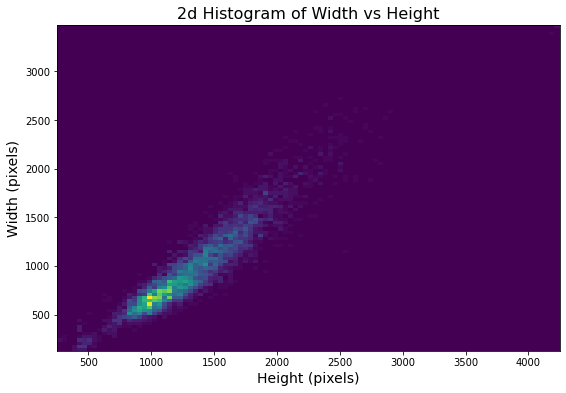

In [ ]:
plt.figure(figsize=(9,6))
plt.title('2d Histogram of Width vs Height', fontsize=16)
plt.xlabel('Height (pixels)',fontsize=14)
plt.ylabel('Width (pixels)',fontsize=14)
plt.hist2d(sizes_df['width'], sizes_df['height'], bins=100);

The plot above is a 2d histogram of width vs height.  The darker (purple) areas are where there are no or less samples.  The brighter (yellow) areas show where there are higher concentrations of samples.  As we can see, we have a lot of images around the 700x1000 size with sizes growing from there but being more spread out.

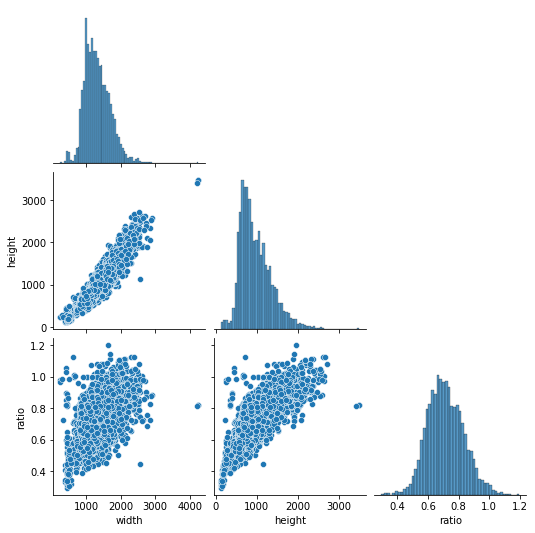

In [ ]:
pairplot(sizes_df,corner=True)

Some takeaways from these plots:


*   Mean ratio is ~ 0.7 (height / width) 
*   We have a few outliers, but the majority of our data (25th to 75th) falls in these ranges: width = (688 to 1194), and height = (1056 to 1560)

An idea would be to test models with our images reshaped to sizes based on the above findings, but later testing determined that using transfer learning would be an overall a better option for us which ends up constraining our possible image sizing.  For example, we may have wanted to try a model with images of size (668,1056), but if we use Resnet, then we need to use (224,224).  Reshaping to keep the mean ratio of 0.7 (along with padding) was tested, but didn't improve the model, so the idea was discarded.



### 2. Input Pipeline

Pytorch requires our data to be in a 'Dataset' class which is later passed to a 'Dataloader' that fetches images in batches and performs all prepossessing and transformations before passing along to the model.

In [12]:
#Starter code here: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class ChestXrayDataset(Dataset):
    """Chest Xrays dataset."""

    def __init__(self, root_dir, image_names, labels, transform=None):
        """
        Args:
            root_dir (string): Base directory.
            image_names(list, str): Paths to images
            labels(list, int64): Encoded labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.image_names[idx])
        #image = io.imread(img_name,as_gray=True)
        image = Image.open(img_name)
        label = self.labels.iloc[idx]
        sample = {'image': image, 'label': label}
        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

### Image Normalization/standardization
We are going to want to standardize our data ((x - mean)/std).  However, we need to manually caluclate the mean and std by iterating over our dataset. Below we are creating a dataset from our image paths and labels.  The transformations are not carried out at this time, but will be performed when the images are processed by the dataloader.

In [ ]:
norm_dataset = ChestXrayDataset(root_dir=base_path + 'train/', image_names=df_train['image_paths'], labels=df_train['labels'],transform=transforms.Compose([
                                               #resizing to our input size                                                                                                                 
                                               transforms.Resize((224,224)),
                                               #ensuring all images are 3 channel
                                               transforms.Grayscale(num_output_channels=3),
                                               transforms.ToTensor()
                                           ]))

Below we are creating the dataloader which is a generator that we can call to fetch our images and put them through our list of transformations above.

In [ ]:
loader = DataLoader(norm_dataset,
                         batch_size=16,
                         num_workers=16,
                         shuffle=False)

Now we can iterate through our entire dataset to calculate the mean and standard deviation which we can then use to standardize our data ((data - mean)/std).

In [ ]:
#from https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560/5
# The code is from ptrblck who is extremely helpful in the pytorch forums 

mean = 0.
std = 0.
for i, data in enumerate(loader,0):
    images = data['image']
    images.to(device)
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)

In [ ]:
print(mean)
print(std)

tensor([0.4829, 0.4829, 0.4829])
tensor([0.2213, 0.2213, 0.2213])


### Create train and test datasets
We don't have a large amount of images (only ~5000 for training), so we will be relying heavily on transformations to 'create' new data.  It's not as good as having more data, but it's definitely quicker and easier.

In [13]:
train_dataset = ChestXrayDataset(root_dir=base_path + 'train/', 
                                       image_names=df_train['image_paths'], 
                                       labels=df_train['labels'],
                                           transform=transforms.Compose([
                                               transforms.Resize((256,256)),
                                               transforms.Grayscale(num_output_channels=3), #ensure all images have 3 channels
                                               transforms.RandomCrop(224),
                                               transforms.ColorJitter(brightness=.2, contrast=.2), #to account for the variation of brightness/contrast in xrays
                                               #transforms.RandomHorizontalFlip(p=0.5),
                                               transforms.RandomRotation(degrees=15), #most xrays are aligned fairly vertical so we will only rotate 10 degrees
                                               #transforms.RandomAffine(0, translate=(.1,.1), scale=(.9,.9), shear=0),
                                               transforms.ToTensor(),
                                               #transforms.RandomErasing(),
                                               transforms.Normalize((0.4829, 0.4829, 0.4829), (0.2213, 0.2213, 0.2213))
                                           ]))

test_dataset = ChestXrayDataset(root_dir=base_path + 'test/', image_names=df_test['image_paths'], labels=df_test['labels'],transform=transforms.Compose([
                                               transforms.Resize((256,256)),
                                               transforms.Grayscale(num_output_channels=3),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.4829, 0.4829, 0.4829), (0.2213, 0.2213, 0.2213))
                                           ]))

#### Visualize transformed data  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


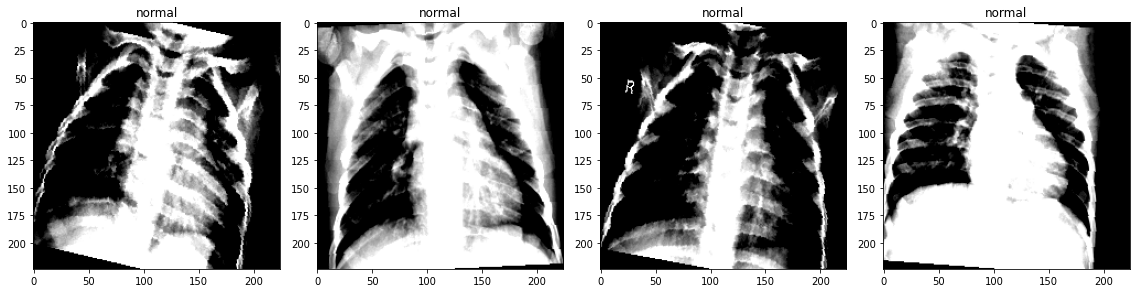

In [ ]:
class_names = ['normal', 'virus','bacteria']

fig = plt.figure(figsize=(16,9))
sample = train_dataset[65]
for i, data in enumerate(train_dataset,0):
    image, label = data['image'], data['label']

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(class_names[label])
    plt.imshow(image.permute(1, 2, 0),cmap='gray')
    if i == 3:
      break
plt.show();

The strange levels of darkness/brightness are due to the effect of normalization.  We can also see some of these images have been flipped and rotated slightly as well.  Care was taken to avoid drastic data augmentation because this model would likely see images that are very simliar in regard to orientation, brightenss, etc.

#### Dataloaders
Pytorch has a system for loading data which uses a generator.  We will be setting up our loader to process 8 images at a time.  Note that we are only shuffling the trainloader.  

Multiple batch sizes ranging from 2 to 32 were tested, but best results came from a batch size of 8.

In [14]:
trainloader = DataLoader(train_dataset, batch_size=8,
                        shuffle=True, num_workers=8)

testloader = DataLoader(test_dataset, batch_size=8,
                        shuffle=False, num_workers=8)

Now that we've got our pipeline setup, let's move on to modeling!

## 3. Modeling
Due to the lack of data and initial testing with a basic CNN, a decision was made to focus on transfer learning for this problem.  We will talk more about that in a bit, but first let's start by getting an idea of our null model.  We have three classes ('Normal', 'Virus', 'Bacteria').  The simplest model we can create would be to always output the largest class:

In [ ]:
#Getting the numbers of each category
df_test['labels'].value_counts()

2    242
0    232
1    148
Name: labels, dtype: int64

In [ ]:
#Dividing the largest catergory but the total number of samples
df_test['labels'].value_counts().max() / df_test['labels'].value_counts().sum()

0.3890675241157556

So, we need to at least do better than 38%!  

**A keen observer might remember that our combined train/test dataset actually has 47% of samples belonging to one class.  Normally, we would want to have that same ratio in our test set as well, however we know that we have at least a small amount of non-independance from the presence of CT scans (multiple scans from the same person).  We don't want to shuffle our train and test sets together because that might artificially inflate our results by including representations of the same person in both datasets.

Now that we have at least a baseline idea of how we should be performing, let's get ready to model.  Below is a helper function for training our models.  It will train on an epoch, update the weights, and then run a validation pass and save the results.  After all epochs have been completed, the function will reload the weights that gave the best validation results.

In [15]:
# starter code here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase],0):
                inputs, labels = data['image'], data['label']

                #send tensors to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                #learning rate decay
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Our helper function requires a dicitonary that contains our dataloaders as well as a dictionary containing the lengths of the datasets.

In [16]:
dataloaders = {'train': trainloader, 'val': testloader}
              
dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}

### A note on transfer learning
Transfer Learning is a very popular technique in computer vision (and also increasingly popular in NLP after the introduction of transformer models). The basic idea is to take a model that has been trained on a very large dataset for many many epochs and 'fine-tune' it for a narrower problem.  Often times these models have been trained on something like [ImageNet](https://en.wikipedia.org/wiki/ImageNet) which has ~14million images and over 20k categories.  The fine-tuneing involves removing the final output layer, replacing it with your own (in our case a fully connected layer with 3 nodes) and then unfreezing various layer weights so that they can learn more about your images.

Both ResNet18 and ResNet50 were tested.  The latter of the two tended to overfit, so more time was spent fine tuneing the former.

In [29]:
model_conv = torchvision.models.resnet18(pretrained=True)
#model_conv = torchvision.models.resnet50(pretrained=True)

The parameters of a pretrained model are frozen by default, so we will need to decide which layers to unfreeze.  The general process followed was to start by only training the output layer and then incrementally unfreezing more layers.  ResNet uses residual blocks which have multiple layers contained in them, so when we unfreeze a block, we are actually unfreezing multiple layers. 

The following code is what we use to unfreeze the weights, add our output layer, instantiate our loss function, instantiate our optimizer, and also to instantiate our learning rate scheduler which decays our learning rate over time.

In [ ]:
#Each child is a either a residual block, or a standalone layer
#Decreasing the number in the 'if count >= num' statement causes more layers/blocks to be unfrozen.
# 'if count >= num' means that only the first 6 layers (or blocks) are frozen.
count = 0
for child in model_conv.children():
    count += 1
    if count >= 7:
      #print('Unfreezing layer/block',+ count)
      #looping over residual blocks to unfreeze all layers
      for param in child.parameters():
          param.requires_grad = True
          print('Unfreezing layer/block',+ count)
# Adding our output layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
#our output layer for 3 classes
model_conv.fc = nn.Linear(num_ftrs, 3)

#sending to gpu
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

#optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.parameters())
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Training the model
Now that we have our model setup with our chosen layers unfrozen, we can begin training!

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

The best performing model got 90.2% acc on the validation set, however it wasn't saved.  We were able to train another model to get 87% which is also not too bad.  An idea for future improvement would be to create a dataframe to record and keep track of model performance metrics as a dictionary of the parameters.  It could be referenced to help tune new models. Next time...

In [19]:
#Saving models that performed well
#torch.save(model_conv.state_dict(), base_path + 'test_model')

res18_normalized_8lay_8b 87%

In [31]:
#Loading model with gpu
model_conv.load_state_dict(torch.load(base_path + 'res18_normalized_8lay_8b'))
#if no gpu available:
#model_conv.load_state_dict(torch.load(base_path + 'res_tuned_90', map_location=torch.device('cpu')))

<All keys matched successfully>

## 4. Model Evaluation

In order to evaluate our model, we will need to get our predictions.  We trained our model on batches of 32 images, but it will be much easier to work with our predictions if we only pass 1 image at a time.  We can do this using the same DataLoader, but changing the batch size.  Num_workers has also been changed to 0 (which defaults to the main process).

In [32]:
testloader = DataLoader(test_dataset, batch_size=1,
                        shuffle=False, num_workers=0)

Now we can get our predictions!  Below is our evaluation loop.  We turn off gradient tracking to save memory (we won't be updating the weights).  This loop will give us our loss and accuracy as well as saving the predictions.

In [33]:
all_preds = []

#turning off gradient tracking
with torch.no_grad():
  model_conv.eval()

  running_loss = 0.0
  running_corrects = 0

  #iterate over dataset
  for i, data in enumerate(testloader,0):
      inputs, labels = data['image'], data['label']

      #send to gpu
      inputs = inputs.to(device)
      labels = labels.to(device)

      #forward pass
      outputs = model_conv(inputs)

      #get prediction
      _, preds = torch.max(outputs, 1)

      #save prediction
      all_preds.append(preds)

      #get loss
      loss = criterion(outputs, labels)

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / len(test_dataset)
      epoch_acc = running_corrects.double() / len(test_dataset)

  print('{} Loss: {:.4f} Acc: {:.4f}'.format(
      'Val', epoch_loss, epoch_acc))

Val Loss: 0.4553 Acc: 0.8750


87.5% acc on the validation set.  Not too bad!  Let's dive a little deeper now and check out our confusion matrix.

In [25]:
# Starter code from: https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=12)

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    plt.tight_layout();

Normalized confusion matrix
[[0.83 0.14 0.03]
 [0.01 0.76 0.23]
 [0.01 0.   0.98]]


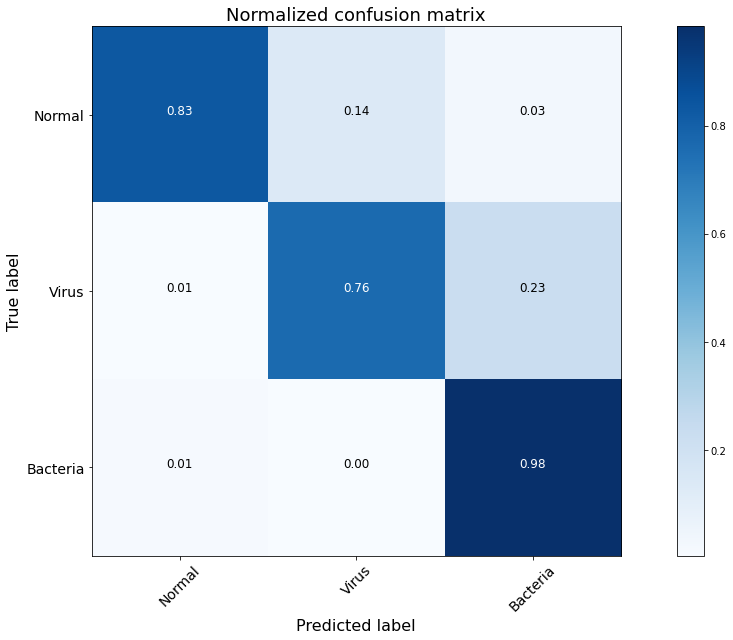

In [43]:
cm = confusion_matrix(df_test[['labels']], all_preds_np)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(16,9))
plot_confusion_matrix(cm, classes=['Normal','Virus','Bacteria'],
                      title='Normalized confusion matrix',normalize=True);

The plot above explains a lot!  First lets take a look at the top row (True label: Normal) The model does fairly well at 

If you look at the left column, we can see that if someone does have some type of pneumonia (virus or bacteria), the model does well at predicting they are sick.  Expanding on this, if we look at the center row (True label: Virus), we can see that when someone has viral pneumonia, the model gets confused as to which type they actually have.  

### Visualize False Predictions
It might be helpful to visualize some of the false predictions.  It could possibly give us direction on future steps to take in order to improve the model. If we see a common feature showing up in the false predictions, then perhaps we could gather similar images so we can build a more robust model.

In [90]:
#helper function to plot predictions
def visualize_predictions(imgs, true_labels, predicted_labels, title,offset=0):
    plt.figure(1, figsize=(25,25))
    for i in range(3):
        j = i + offset #change offset to get different images
        plt.subplot(3,3, i+1)
        plt.subplots_adjust(hspace = .5 , wspace = .2)#adjust spacing
        im = Image.open(base_path + 'test/'+imgs[j])#open image from path
        plt.imshow(im,cmap='gray')
        plt.title('True {} : Pred {}'.format(true_labels[j], int(predicted_labels[j])), fontsize=25)
        plt.suptitle(title, fontsize=35,x=0.5, y=.92)
        plt.xticks([]) , plt.yticks([])
    plt.show()

Now let's organize our false predicitons a bit.  First we need to bring the prediction tensors to the cpu and then convert them to numpy.  After that we can throw them in with our original test dataframe which contains labels and image paths.

In [82]:
#all_preds is a list of predctions, but they are all tensors
#this will take each tensor, send it to the cpu, and then convert to numpy
all_preds_np = [x[0].cpu().numpy() for x in all_preds]

preds_df = df_test
preds_df['predictions'] = all_preds_np #addend prediction column

#getting false positives
fp_df = preds_df.loc[(preds_df['labels'] == 0) & (preds_df['predictions'] != 0)]
fp_df = fp_df.reset_index(drop=True)

#getting false negatives
fn_df = preds_df.loc[(preds_df['labels'] != 0) & (preds_df['predictions'] == 0)]
fn_df = fn_df.reset_index(drop=True)

Now let's see a few!

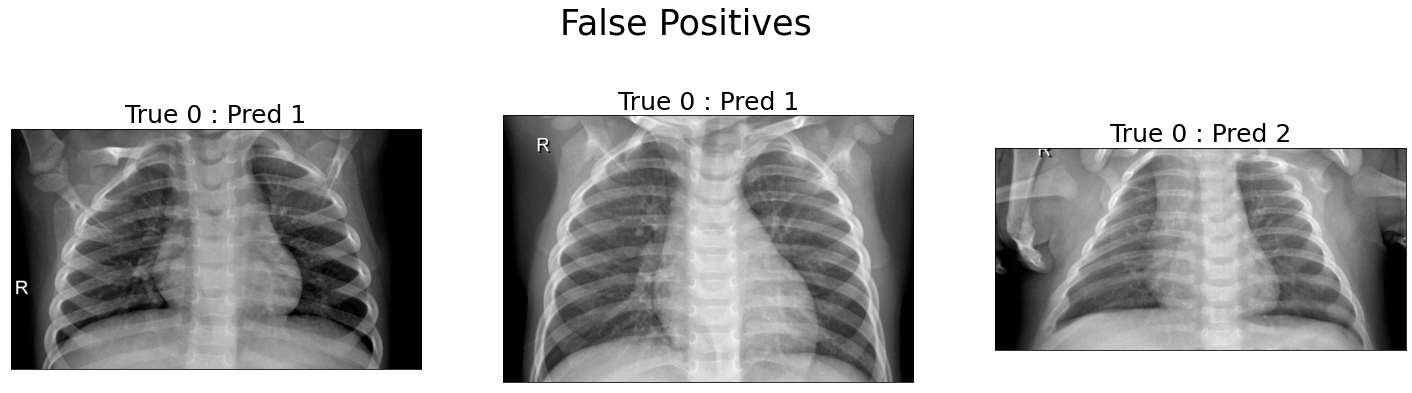

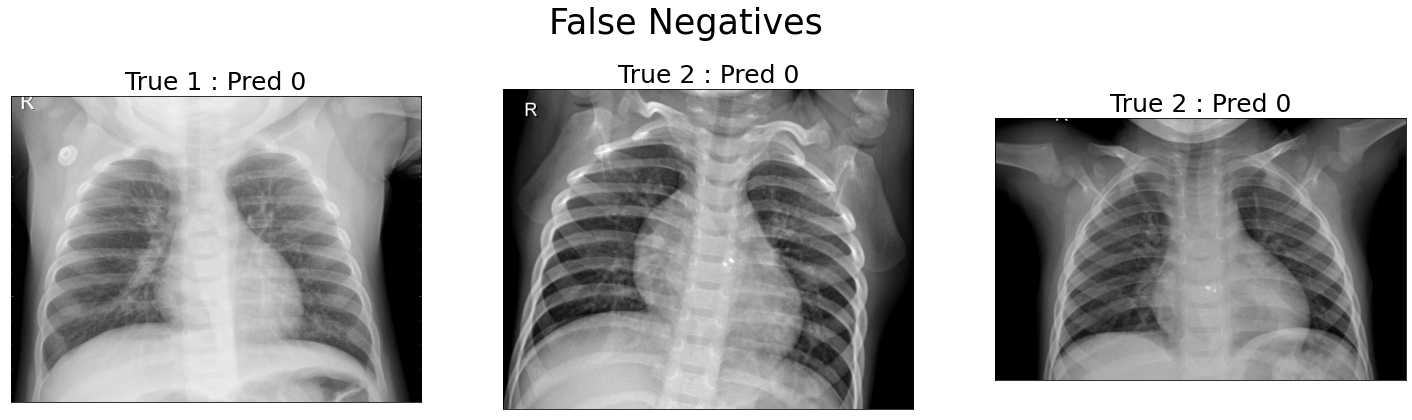

In [93]:
visualize_predictions(fp_df['image_paths'],fp_df['labels'],fp_df['predictions'], title='False Positives',offset=0)
visualize_predictions(fn_df['image_paths'],fn_df['labels'],fn_df['predictions'], title='False Negatives',offset=0)

Looking at these images can really make one appreciate the skill that doctors and radiologists have.  It is very difficult to find any kind of pattern as a non-medical expert.

## 5. Conclusions


The goal of this project was to train a model which could potentially be used to aid doctors in diagnosing various types of pneumonia from viewing a chest x-ray.  We had arbitrarily chosen the following metrics to determine success:



*   False Negative rate < 2%
*   False Positive rate < 10%

Our model was able to acheive the first goal of <2% FNR, however, it was unable to achieve the second goal with the FPR sitting at 17%.  Due to the FPR being too high, we do not yet feel that this model is ready to be used in production.  Thankfully, there is still room to grow.  We will cover that next.

## 6. Next Steps

Deep learning algorithms are very data hungry, so one of the major bottlenecks in this project was having enough data.  We scored fairly well on our success metrics with the data we had, but having more would likely help to improve the model.

The loss function chosen was Categorical Cross Entropy, which does not minimize for our success metrics.  Creating a custom loss function could possibly work better.  This was not explored due to time constraints.

Our model was trained on only three categories (normal, virus, bacteria), however, our dataset actually included multiple other subcategories such as COVID-19.  Unfortunately, the amount of samples for these other sub-classes were too low to be able to use them as their own standalone category for training.  Possible datasets have been identified, however, due to time constraints, they were not included.  This is something that we would like to explore further.